## STOCK PREDICTION MODEL = *TOMORROW UP OR DOWN*

-  Stock used en the model = Ecopetrol (EC)
-  Direct Variable used in the model =  WTI CRUDE (CL=F)

In [2]:
import sys
print("Ambiente activo:", sys.executable)

Ambiente activo: /opt/anaconda3/envs/midterm-ml-2025/bin/python


In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import os

In [4]:
import sys
print("Ambiente activo:", sys.executable)

Ambiente activo: /opt/anaconda3/envs/midterm-ml-2025/bin/python


In [29]:
pa_ticker = input("Por favor, digita el Ticker del Activo Principal (ej: EC): ") # Aquí se guarda lo que digita el usuario.
ca_ticker = input("Por favor, digita el Ticker del Activo Correlacionado (ej: CL=F): ") # Y aquí el segundo.

Por favor, digita el Ticker del Activo Principal (ej: EC):  EC
Por favor, digita el Ticker del Activo Correlacionado (ej: CL=F):  CL=F


In [30]:
# Descargar Activo Principal (PA)
print(f"Downloading principal asset: {pa_ticker}...") # Replace pa_ticker for Principal Asset TICKET
df = yf.download(pa_ticker, period="10y", interval="1d", progress=False, auto_adjust=False)
df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
# Usando f-strings para renombrar las columnas dinámicamente
df.columns = [f'{pa_ticker}_Open', f'{pa_ticker}_High', f'{pa_ticker}_Low', f'{pa_ticker}_Close', f'{pa_ticker}_Volume']
print(f"Principal asset: {len(df)} filas")
# =============================
# Descargar Activo Correlacionado (CA)
print(f"Downloading correlated asset: {ca_ticker}...") # Replace pa_ticker for correlated Asset TICKET
ca_df = yf.download(ca_ticker, period="10y", interval="1d", progress=False, auto_adjust=False)
ca_df = ca_df[['Open', 'High', 'Low', 'Close', 'Volume']]
# Usando f-strings para renombrar las columnas dinámicamente
ca_df.columns = [f'{ca_ticker}_Open', f'{ca_ticker}_High', f'{ca_ticker}_Low', f'{ca_ticker}_Close', f'{ca_ticker}_Volume']
# NOTA: Corregí el error, deberías usar 'ca_df' en este print
print(f"Correlated asset downloaded: {len(ca_df)} filas")

print(f"Columns principal asset download:", df.columns.tolist())

Principal asset: 2514 filas
Correlated asset downloaded: 2515 filas
Columns principal asset download: ['EC_Open', 'EC_High', 'EC_Low', 'EC_Close', 'EC_Volume']


In [31]:
# #Download principal asset
# print("Downloading principal asset...")
# df = yf.download("PA", period="10y", interval="1d", progress=False, auto_adjust=False)
# df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
# df.columns = ['PA_Open', 'PA_High', 'PA_Low', 'PA_Close', 'PA_Volume']
# print(f"Principal asset: {len(df)} filas")
# print(f"Columns principal asset download:", df.columns.tolist())


In [32]:
# #Download correlated asset
# print("Downloading CA (CL=F)...")
# ca_df = yf.download("CL=F", period="10y", interval="1d", progress=False, auto_adjust=False)
# ca_df = ca_df[['Open', 'High', 'Low', 'Close', 'Volume']]
# ca_df.columns = ['CA_Open', 'CA_High', 'CA_Low', 'CA_Close', 'CA_Volume']
# print(f"Correlated asset downloaded:" {len(ca_df)} filas")


In [33]:
# #Align assets (principal with correlated)
# df['CA_Close'] = ca_df['CA_Close'].reindex(df.index).ffill()
# ==================================================

# Celda 68 - ADAPTACIÓN Y ALINEACIÓN DE ACTIVOS

# --- 1. Alineación y Estandarización de CA ---
# El error original era aquí: 'CA_Close' no existía en ca_df.
# Ahora usamos el ticker real (CL=F, por ejemplo) y lo alineamos al df principal.
df['CA_Close'] = ca_df[f'{ca_ticker}_Close'].reindex(df.index).ffill() 

# Opcional: Traer el resto de las columnas del activo correlacionado por si se necesitan.
df['CA_Open'] = ca_df[f'{ca_ticker}_Open'].reindex(df.index).ffill()
df['CA_High'] = ca_df[f'{ca_ticker}_High'].reindex(df.index).ffill()
df['CA_Low'] = ca_df[f'{ca_ticker}_Low'].reindex(df.index).ffill()
df['CA_Volume'] = ca_df[f'{ca_ticker}_Volume'].reindex(df.index).ffill()


# --- 2. Estandarización de PA ---
# Crear las columnas genéricas del Activo Principal (PA) en df 
# (ej: 'EC_Close' pasa a llamarse 'PA_Close' para el resto del código)
df['PA_Open'] = df[f'{pa_ticker}_Open']
df['PA_High'] = df[f'{pa_ticker}_High']
df['PA_Low'] = df[f'{pa_ticker}_Low']
df['PA_Close'] = df[f'{pa_ticker}_Close']
df['PA_Volume'] = df[f'{pa_ticker}_Volume']

# Eliminar las filas con NaN que quedan después de la alineación
df = df.dropna()

print(f"DataFrames alineados. Filas finales: {len(df)}")

DataFrames alineados. Filas finales: 2514


In [34]:
# #Built Features
# df['CA_Change'] = df['CA_Close'].pct_change()
# df['PA_CA_Ratio'] = df['PA_Close'] / (df['CA_Close'] + 1e-8)
# df['CA_Volatility'] = df['CA_Close'].rolling(14).std()

# print("\nFeatures of correlated asset builts correctly.")
# print(df[['PA_Close', 'CA_Close', 'PA_CA_Ratio']].head(3))
# ==========================================================

# Celda 36 - Built Features (NO NECESITA CAMBIOS DESPUÉS DE LA ADAPTACIÓN)
df['CA_Change'] = df['CA_Close'].pct_change()
df['PA_CA_Ratio'] = df['PA_Close'] / (df['CA_Close'] + 1e-8)
df['CA_Volatility'] = df['CA_Close'].rolling(14).std()

print("\nFeatures of correlated asset builts correctly.")
print(df[['PA_Close', 'CA_Close', 'PA_CA_Ratio']].head(3))



Features of correlated asset builts correctly.
            PA_Close   CA_Close  PA_CA_Ratio
Date                                        
2015-11-11      9.21  42.930000     0.214535
2015-11-12      8.87  41.750000     0.212455
2015-11-13      8.72  40.740002     0.214040


In [35]:
#RENOMBRAR PARA ML
df['Close'] = df['PA_Close']  # Para mantener compatibilidad con tu código
df['Volume'] = df['PA_Volume']

#FEATURES TÉCNICAS (SMA, RSI, etc.)
df['SMA_100'] = df['Close'].rolling(100).mean()

In [36]:
# DEFINICION SW LA FUNCION PARA CALCULAR EL RSI
def calculate_rsi(data, periods=14):
    delta = data.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=periods).mean()
    avg_loss = loss.rolling(window=periods).mean()
    rs = avg_gain / avg_loss
    rs = rs.replace([np.inf, -np.inf], np.nan)
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI_14'] = calculate_rsi(df['Close'])

#NUEVAS FEATURES TÉCNICAS
df['Overbought'] = (df['RSI_14'] > 70).astype(int)
df['Oversold'] = (df['RSI_14'] < 30).astype(int)
df['Below_SMA'] = (df['Close'] < df['SMA_100']).astype(int)
df['High_Volume'] = (df['Volume'] > df['Volume'].rolling(20).mean()).astype(int)

In [37]:
#VARIABLE OBJETIVO
df['Tomorrow_Close'] = df['Close'].shift(-1)
df['Target'] = (df['Tomorrow_Close'] < df['Close']).astype(int)  # 1 = baja

In [38]:
#LISTA FINAL DE FEATURES
features = [
    'Close', 'Volume', 'SMA_100', 'RSI_14',
    'Overbought', 'Oversold', 'Below_SMA', 'High_Volume',
    #'WTI_Close', 'WTI_Change', 'EC_WTI_Ratio', 'WTI_Volatility'
    'CA_Close', 'CA_Change', 'PA_CA_Ratio', 'CA_Volatility'
]  

# # Celda 40 - LISTA FINAL DE FEATURES (CORREGIDA)
# features = [
#     'Close', 'Volume', 'SMA_100', 'RSI_14',
#     'Overbought', 'Oversold', 'Below_SMA', 'High_Volume',
#     # Nombres genéricos y corregidos (usan 'CA' y 'PA' en lugar de 'WTI' y 'EC')
#     'CA_Close', 'CA_Change', 'PA_CA_Ratio', 'CA_Volatility' 
# ]

In [39]:
#DATAFRAME PARA ML
df_ml = df[features + ['Target']].copy()
df_ml = df_ml.dropna().reset_index(drop=True)
print(f"\nFilas finales para ML: {len(df_ml)}")
print(f"Correlación PA - CA: {df['Close'].corr(df['CA_Close']):.3f}")


Filas finales para ML: 2408
Correlación PA - CA: 0.213


In [40]:
print(df[['Close', 'CA_Close']].head(3))

            Close   CA_Close
Date                        
2015-11-11   9.21  42.930000
2015-11-12   8.87  41.750000
2015-11-13   8.72  40.740002


ANÁLISIS EXPLORATORIO DE DATOS (EDA)


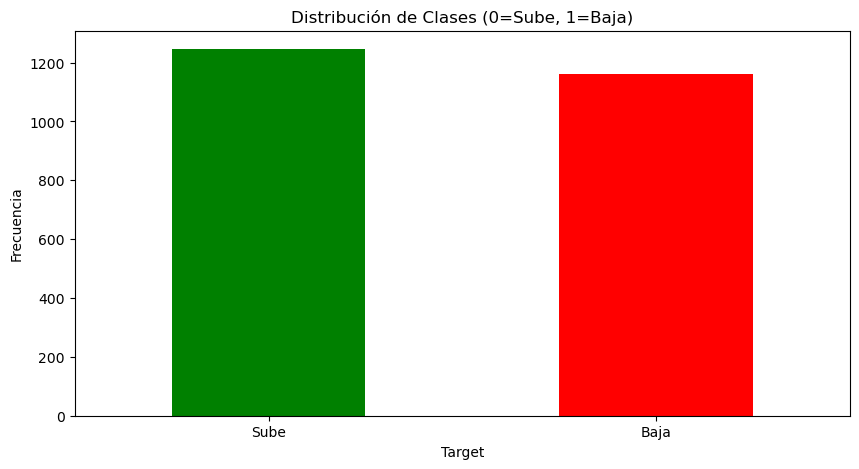

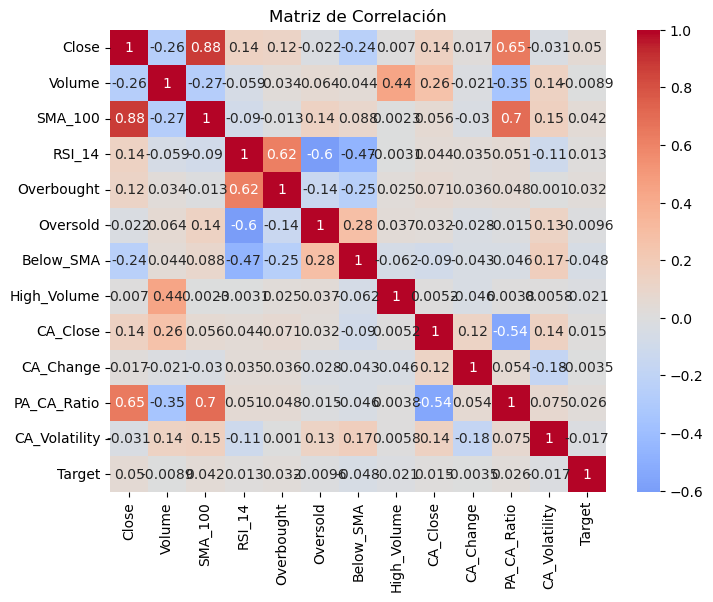

In [41]:
# --- 5. EDA ---
print("ANÁLISIS EXPLORATORIO DE DATOS (EDA)")

# Distribución del target

plt.figure(figsize=(10,5))
df_ml['Target'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribución de Clases (0=Sube, 1=Baja)')
plt.xticks([0,1], ['Sube', 'Baja'], rotation=0)
plt.ylabel('Frecuencia')
plt.show()

# Correlación
plt.figure(figsize=(8,6))
sns.heatmap(df_ml[features + ['Target']].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación')
plt.show()

In [42]:
#DIVISIÓN TRAIN/TEST ---
X = df_ml[features]
y = df_ml['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False  # ¡Importante: serie temporal!
)

print(f"Train: {len(X_train)} | Test: {len(X_test)}\n")

Train: 1926 | Test: 482



In [43]:
#BASELINE MODEL ---
baseline_acc = max(y_test.value_counts()) / len(y_test)
print(f"Baseline (predicción mayoritaria): {baseline_acc:.3f}\n")

Baseline (predicción mayoritaria): 0.525



In [44]:
#ENTRENAR MÚLTIPLES MODELOS ---
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: {acc:.3f}")


Logistic Regression: 0.525
Random Forest: 0.521
KNN: 0.527
XGBoost: 0.525


/opt/anaconda3/envs/midterm-ml-2025/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:22:21] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [45]:
#ENTRENAR Y COMPARAR 4 MODELOS ---
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"{name}: {acc:.3f}")

#MEJOR MODELO ---
best_name = max(results, key=results.get)
best_model = models[best_name]
print(f"\nMEJOR MODELO: {best_name} → {results[best_name]:.3f}")

Logistic Regression: 0.525
Random Forest: 0.521
KNN: 0.527
XGBoost: 0.525

MEJOR MODELO: KNN → 0.527


/opt/anaconda3/envs/midterm-ml-2025/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:22:22] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Classification Report:
              precision    recall  f1-score   support

        Sube       0.54      0.60      0.57       253
        Baja       0.50      0.44      0.47       229

    accuracy                           0.53       482
   macro avg       0.52      0.52      0.52       482
weighted avg       0.52      0.53      0.52       482



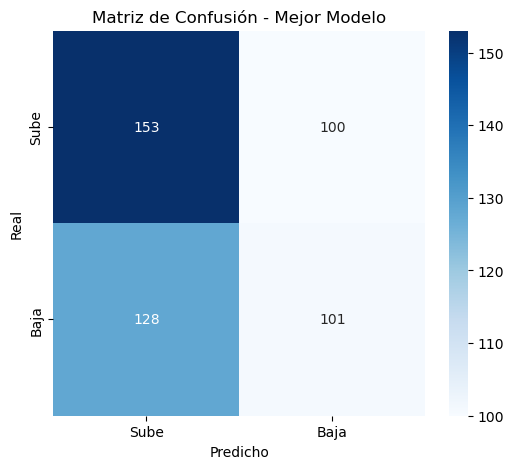

In [46]:
#EVALUACIÓN DETALLADA
y_pred = best_model.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Sube', 'Baja']))

#Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Sube', 'Baja'], yticklabels=['Sube', 'Baja'])
plt.title('Matriz de Confusión - Mejor Modelo')
plt.ylabel('Real')
plt.xlabel('Predicho')
plt.show()

In [47]:
#To save model
os.makedirs('data', exist_ok=True)
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(features, 'data/features.pkl')
print("\nModel saved as 'best_model.pkl'")


Model saved as 'best_model.pkl'


In [48]:
#Export Data
df_ml.to_csv('data/PA_processed.csv', index=True)
print("Processed data save in 'data/PA_processed.csv'")

Processed data save in 'data/PA_processed.csv'


In [49]:
print("Columns in original df:", df.columns.tolist())
print("Columns in df_ml:", df_ml.columns.tolist())
print("Rows in df_ml after of dropna:", len(df_ml.dropna()))

Columns in original df: ['EC_Open', 'EC_High', 'EC_Low', 'EC_Close', 'EC_Volume', 'CA_Close', 'CA_Open', 'CA_High', 'CA_Low', 'CA_Volume', 'PA_Open', 'PA_High', 'PA_Low', 'PA_Close', 'PA_Volume', 'CA_Change', 'PA_CA_Ratio', 'CA_Volatility', 'Close', 'Volume', 'SMA_100', 'RSI_14', 'Overbought', 'Oversold', 'Below_SMA', 'High_Volume', 'Tomorrow_Close', 'Target']
Columns in df_ml: ['Close', 'Volume', 'SMA_100', 'RSI_14', 'Overbought', 'Oversold', 'Below_SMA', 'High_Volume', 'CA_Close', 'CA_Change', 'PA_CA_Ratio', 'CA_Volatility', 'Target']
Rows in df_ml after of dropna: 2408


In [50]:
# See Distribution of classes

print("Distribución en TEST:")
print(y_test.value_counts(normalize=True).round(3))

#Models results
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}: {acc:.3f}")

Distribución en TEST:
Target
0    0.525
1    0.475
Name: proportion, dtype: float64
Logistic Regression: 0.525
Random Forest: 0.521
KNN: 0.527
XGBoost: 0.525


/opt/anaconda3/envs/midterm-ml-2025/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [23:22:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1758007651359/work/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [51]:
# To Save data in container
df_ml.to_csv('data/df_ml.csv', index=False)
print("Datos guardados en data/df_ml.csv")

Datos guardados en data/df_ml.csv


In [52]:
# Proof of testing list of features
import joblib
features = joblib.load('data/features.pkl')
print(features)

['Close', 'Volume', 'SMA_100', 'RSI_14', 'Overbought', 'Oversold', 'Below_SMA', 'High_Volume', 'CA_Close', 'CA_Change', 'PA_CA_Ratio', 'CA_Volatility']


In [53]:
# ===============================================
# Generate Predictions With The Model
# ===============================================

import joblib
import pandas as pd

# --- Upload Model And Features  ---
model = joblib.load('best_model.pkl')
features = joblib.load('data/features.pkl')

print(f"Model upload: {type(model).__name__}")
print(f"Features expected ({len(features)}): {features}")

# --- Verify That "df" Has All Features ---
missing = [f for f in features if f not in df.columns]
if missing:
    print(f"ERROR: Faltan columnas: {missing}")
else:
    print("All features are presents")
# This line let manage the NaN values in X    
df.dropna(subset=features, inplace=True)

# --- Generate Predictions ---
X = df[features]  # Only columns that The Model Needs
df['prediction'] = model.predict(X)

# --- Verify ---
print(f"\nPredictions output: {len(df)} filas")
print("Distribution of Predictionts:")
print(df['prediction'].value_counts().sort_index())

# Example: last 5 predictions
print("\nLast five (5) predictions:")
print(df[['PA_Close', 'Tomorrow_Close', 'Target', 'prediction']].tail())

Model upload: KNeighborsClassifier
Features expected (12): ['Close', 'Volume', 'SMA_100', 'RSI_14', 'Overbought', 'Oversold', 'Below_SMA', 'High_Volume', 'CA_Close', 'CA_Change', 'PA_CA_Ratio', 'CA_Volatility']
All features are presents

Predictions output: 2408 filas
Distribution of Predictionts:
prediction
0    1304
1    1104
Name: count, dtype: int64

Last five (5) predictions:
            PA_Close  Tomorrow_Close  Target  prediction
Date                                                    
2025-11-04      9.26            9.46       0           1
2025-11-05      9.46            9.67       0           0
2025-11-06      9.67            9.92       0           0
2025-11-07      9.92            9.88       1           0
2025-11-10      9.88             NaN       0           1


Starting comparative backtest ...


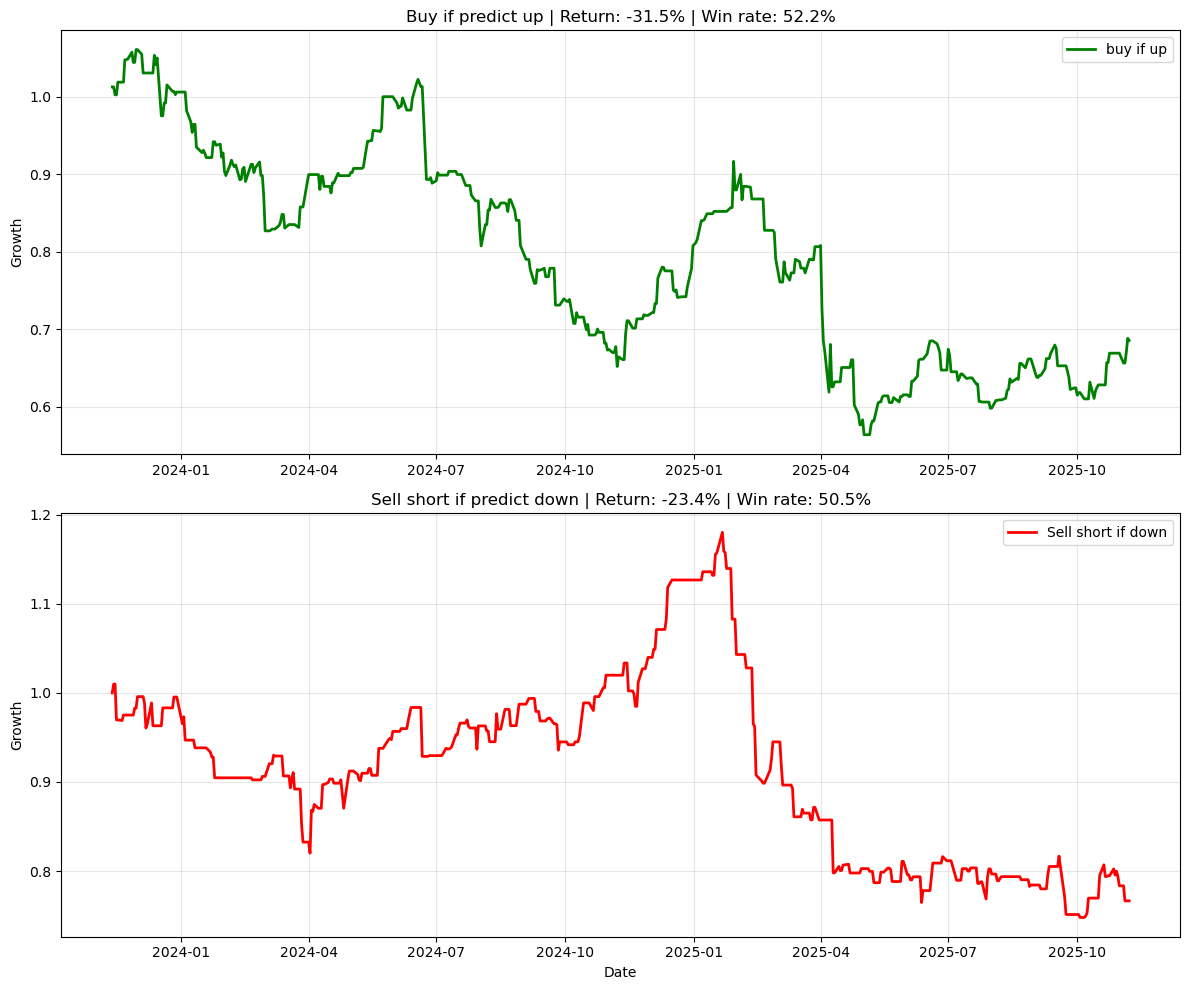


BACKTEST COMPARATIVE - PA
Estrategy                 Trades   Win rate   Return total
----------------------------------------------------------------------
Buy if goes up            291      52.2%      -31.5%
Sell if down              208      50.5%      -23.4%


In [54]:
# ===============================================
# 17. BACKTEST 2 YEARS: BUY vs SELL (SHORT SELL)
# ===============================================

import numpy as np
import matplotlib.pyplot as plt

print("Starting comparative backtest ...")

# --- Prepair Data ---
df_backtest = df.copy()
df_backtest = df_backtest.sort_index()
end_date = df_backtest.index[-1]
start_date = end_date - pd.Timedelta(days=730)
df_backtest = df_backtest[df_backtest.index >= start_date].copy()

df_backtest = df_backtest.dropna(subset=['prediction', 'Tomorrow_Close', 'PA_Close'])
df_backtest['daily_return'] = (df_backtest['Tomorrow_Close'] - df_backtest['PA_Close']) / df_backtest['PA_Close']

# --- Estrategy 1: Buy if Predict PA Will Up Tomorrow ---
df_backtest['buy_return'] = np.where(df_backtest['prediction'] == 0, df_backtest['daily_return'], 0)
trades_buy = df_backtest[df_backtest['prediction'] == 0]
win_buy = len(trades_buy[trades_buy['daily_return'] > 0])
win_rate_buy = win_buy / len(trades_buy) if len(trades_buy) > 0 else 0
total_buy = (1 + df_backtest['buy_return']).prod() - 1

# --- Estrategy 2: Sell Short If Predict PA Down Tomorrow ---
df_backtest['sell_return'] = np.where(df_backtest['prediction'] == 1, -df_backtest['daily_return'], 0)
trades_sell = df_backtest[df_backtest['prediction'] == 1]
win_sell = len(trades_sell[trades_sell['daily_return'] < 0])
win_rate_sell = win_sell / len(trades_sell) if len(trades_sell) > 0 else 0
total_sell = (1 + df_backtest['sell_return']).prod() - 1

# --- Graphs ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

cum_buy = (1 + df_backtest['buy_return']).cumprod()
ax1.plot(cum_buy, label='buy if up', color='green', linewidth=2)
ax1.set_title(f'Buy if predict up | Return: {total_buy:.1%} | Win rate: {win_rate_buy:.1%}')
ax1.set_ylabel('Growth')
ax1.legend()
ax1.grid(True, alpha=0.3)

cum_sell = (1 + df_backtest['sell_return']).cumprod()
ax2.plot(cum_sell, label='Sell short if down', color='red', linewidth=2)
ax2.set_title(f'Sell short if predict down | Return: {total_sell:.1%} | Win rate: {win_rate_sell:.1%}')
ax2.set_ylabel('Growth')
ax2.set_xlabel('Date')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# --- Final Table ---
print("\n" + "="*70)
print("BACKTEST COMPARATIVE - PA")
print("="*70)

win_rate_buy_str = f"{win_rate_buy:.1%}"
win_rate_sell_str = f"{win_rate_sell:.1%}"
total_buy_str = f"{total_buy:.1%}"
total_sell_str = f"{total_sell:.1%}"

print(f"{'Estrategy':<25} {'Trades':<8} {'Win rate':<10} {'Return total'}")
print("-"*70)
print(f"{'Buy if goes up':<25} {len(trades_buy):<8} {win_rate_buy_str:<10} {total_buy_str}")
print(f"{'Sell if down':<25} {len(trades_sell):<8} {win_rate_sell_str:<10} {total_sell_str}")
print("="*70)